In [2]:
import numpy as np
from math import sqrt

import datetime
import csv
import matplotlib.pyplot as plt

from pyspark.mllib.clustering import KMeans, KMeansModel
from mpl_toolkits.basemap import Basemap

from scipy import ndimage
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

In [3]:
with open('data/detroit.csv') as f:
    csv_file = csv.reader(f)
    next(csv_file)
    crime_list = []
    for row in csv_file:
        crime_list.append(row)

In [4]:
data = []
for row in crime_list:
    crime_date = datetime.datetime.strptime(row[2], '%m/%d/%Y').date()
    crime_pos  = np.array([float(row[-2]), float(row[-1])])
    crime_type = [x.strip() for x in row[3].split(' - ')]
    data.append([crime_date, crime_pos, crime_type])

In [5]:
data_rdd = sc.parallelize(data)
histogram_year_rdd = data_rdd.map(lambda x: (x[0].month, 1)).reduceByKey(lambda x, y: x + y).sortByKey()
year_count = histogram_year_rdd.collect()
histogram_category_rdd = data_rdd.flatMap(lambda x: [(category, 1) for category in x[2]]).reduceByKey(lambda x, y: x + y).sortByKey()
category_count = histogram_category_rdd.collect()

<Container object of 12 artists>

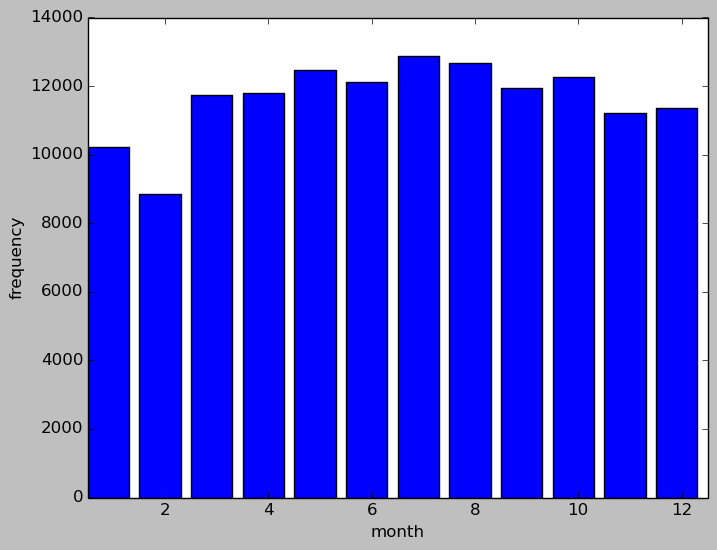

In [6]:
month = [x[0] - 0.5 for x in year_count]
freq = [x[1] for x in year_count]
plt.xlabel('month')
plt.ylabel('frequency')
plt.xlim([0.5,12.5])
plt.bar(month, freq)

<Container object of 449 artists>

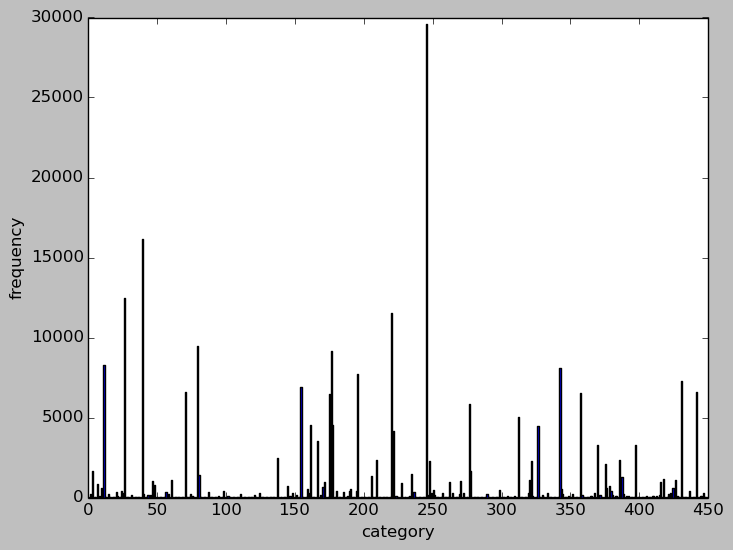

In [7]:
category = [x for x in category_count]
freq = [x[1] for x in category_count]
plt.xlabel('category')
plt.ylabel('frequency')
plt.bar(range(len(category)),freq)

In [8]:
def category_filter(entry, category_types):
    for category in category_types:
        for entry_category in entry:
            if category in entry_category:
                return True
    return False

In [9]:
def cluster(date_range, category_types, num_clusters):
    #Label data
    filtered_rdd = data_rdd.filter(lambda x: x[0].month in date_range and category_filter(x[2], category_types))
    pos_rdd= filtered_rdd.map(lambda x: x[1])
    clusters = KMeans.train(pos_rdd, num_clusters, maxIterations=100, initializationMode="random")
    label_rdd = filtered_rdd.map(lambda x: [x[1], clusters.centers[clusters.predict(x[1])]])
    
    #Cluster and distribution
    return label_rdd, clusters.centers

In [10]:
def sse(point, center):
    return sqrt(sum([i**2 for i in (point - center)]))

In [11]:
#WSSSE = pos_rdd.map(lambda point: sse(point)).reduce(lambda x, y: x + y)
#print("Within Set Sum of Squared Error = " + str(WSSSE))

In [12]:
label, centers = cluster([1, 2, 3, 4], ['MURDER'], 10)
#label=[[point1,center1],[point2,center2],...]

In [19]:
def danger_rdd(months, categories, num_clusters):
    label, centers = cluster(months, categories, num_clusters)
    center_to_errors= label.map(lambda x: (tuple(x[1]),[sse(x[0],x[1])])).reduceByKey(lambda a,b: a+b)
    #[[center,mean,std,count]...]
    center_info= center_to_errors.map(lambda entry:[entry[0],np.average(entry[1]),np.std(entry[1]),len(entry[1])])
    return center_info

danger_zone=danger_rdd([1, 2, 3, 4], ['MURDER'], 10).collect()
danger_zone

[[(42.399926666666673, -83.153333333333336),
  0.021132895769943583,
  0.012265706698806464,
  15],
 [(42.41813333333333, -82.933683333333335),
  0.014280258938350368,
  0.006734078687158555,
  6],
 [(42.428414285714283, -83.057028571428575),
  0.029144932802479474,
  0.0093557705700419991,
  7],
 [(42.3703, -83.014271428571433),
  0.017401656702003158,
  0.010704676507380878,
  7],
 [(42.351630000000007, -83.129770000000008),
  0.020306827464071468,
  0.010603535181459282,
  10],
 [(42.378442857142851, -83.203299999999999),
  0.026047377442196852,
  0.0079613893398346128,
  14],
 [(42.344409090909089, -83.076427272727273),
  0.027255135918080483,
  0.012142727475727576,
  11],
 [(42.418676923076916, -83.24831538461541),
  0.023917133796142406,
  0.01208304356305291,
  13],
 [(42.402887500000006, -82.965049999999991),
  0.0086208189559760003,
  0.0065396922158696812,
  8],
 [(42.431144444444442, -82.985166666666643),
  0.015620165426173461,
  0.006175903989183793,
  18]]

In [14]:
print (centers)

[array([ 42.3703    , -83.01427143]), array([ 42.41274, -83.1515 ]), array([ 42.4306    , -83.00625556]), array([ 42.42141111, -82.97177222]), array([ 42.41531176, -83.23982353]), array([ 42.4155    , -82.93677143]), array([ 42.34440909, -83.07642727]), array([ 42.3691, -83.1871]), array([ 42.42442, -83.06982]), array([ 42.3532 , -83.12735])]


In [64]:
scale=1.5

#for now, only sets markersize ased on count... need to implement blur
def plot_point(x,y,sd,count):
    #create marker image
#     fig2 = plt.figure(2)
#     fig2.clf()
#     ax1= fig2.add_subplot(111)
#     ax1.plot(0.5,0.5,'o',ms=3)
#     ax1.set_ylim(0,1)
#     ax1.set_xlim(0,1)
#     plt.axis('off')
#     fig2.savefig('marker.png', dpi=10)
    
#     print("made figure")
    
#     #plot with Gaussian blur
#     plt.figure(1)
#     #marker = plt.imread('marker.png')
#     markerBlur = ndimage.gaussian_filter(marker,sd)
#     # Create an BboxImage for the blurred marker and add it to the plot. 
#     bb = Bbox.from_bounds(x,y,1,1)  
#     bb2 = TransformedBbox(bb,ax1.transData)
#     bbox_image = BboxImage(bb2,
#                            norm = None,
#                            origin=None,
#                            clip_on=False)
#     bbox_image.set_data(markerBlur)
#     print("s")
#     ax1.add_artist(bbox_image)
    lats=[x]
    lons=[y]
    x,y = map(lons, lats)
    map.plot(x, y, 'bo', markersize=scale*count)

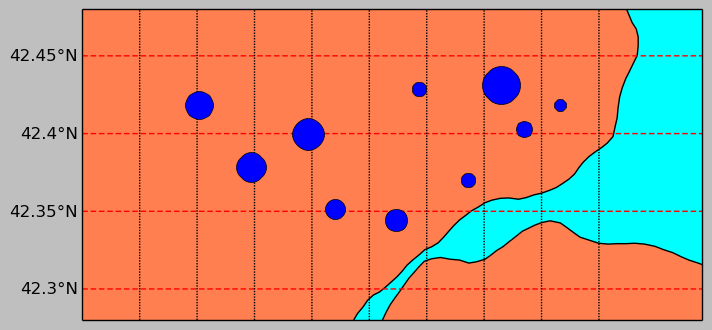

In [65]:
detroit_long= -82.928223
detroit_lat= 42.405678


fig1=plt.figure(1)
ax1=fig1.add_subplot(111)
map = Basemap(projection='merc', lat_0 = detroit_lat, lon_0 = detroit_long,
    resolution = 'f',
    llcrnrlon=-83.35, llcrnrlat=42.28,
    urcrnrlon=-82.81, urcrnrlat=42.48)
 
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()
map.drawstates()
map.drawparallels([x/100.0 for x in range(4210, 4265, 5)], linewidth=1.0, dashes=[4, 2], labels=[1,0,0,0], color='r')
map.drawmeridians([x/100.0 for x in range(-8330, -8285, 5)], labels=[1,0,0,0])

###fixed marker size
#lats=[x[0] for x in centers]
#lons=[x[1] for x in centers]
#x,y = map(lons, lats)
#map.plot(x, y, 'bo', markersize=10)

#plot all centers with varying marker size
for entry in danger_zone:
    plot_point(entry[0][0], entry[0][1], entry[2], entry[3])

plt.show()